In [2]:
from pathlib import Path

import pandas as pd
from google_play_scraper import app
from tqdm import tqdm
import matplotlib.pyplot as plt
from scapy.all import rdpcap

tqdm.pandas()

In [8]:
def get_number_of_flows_per_pcap(pcap_path):
    """
    Given a path to a PCAP file, this function returns the number of unique network flows
    in the file. A flow is defined by a 5-tuple: (source IP, destination IP, source port, 
    destination port, protocol).
    
    Args:
    - pcap_path: Path to the PCAP file.
    
    Returns:
    - int: Number of unique network flows in the PCAP file.
    """
    packets = rdpcap(str(pcap_path))
    
    flows = set()
    
    for packet in packets:
        if 'IP' in packet and ('TCP' in packet or 'UDP' in packet):
            # Extract 5-tuple (source IP, destination IP, source port, destination port, protocol)
            src_ip = packet['IP'].src
            dst_ip = packet['IP'].dst
            if packet.haslayer('TCP'):
                protocol = 'TCP'
                src_port = packet['TCP'].sport
                dst_port = packet['TCP'].dport
            elif packet.haslayer('UDP'):
                protocol = 'UDP'
                src_port = packet['UDP'].sport
                dst_port = packet['UDP'].dport

            flow = (src_ip, dst_ip, src_port, dst_port, protocol)
            flows.add(flow)
    
    return len(flows)

In [3]:
df = pd.read_csv('categories.csv', dtype=str)


In [10]:
path = Path(r"/home/anatbr/students/noamshakedc/da4etc/data/cross_platform")

In [5]:
def get_app_genre(app_id, country='us'):
    country = country.lower()
    if country == 'india':
        country = 'in'
    elif country == 'us' or country == 'usa':
        country = 'us'
    elif country == 'china':
        country = 'cn'
    try:
        return app(app_id, country=country)['genre']
    except Exception as e:
        return str(e)

In [6]:
app_genres = df.progress_apply(lambda row: get_app_genre(row.extracted_raw_name) if row.os == 'Android' else '', axis=1)

100%|██████████| 520/520 [02:33<00:00,  3.40it/s]


In [15]:
df.raw_name

0               china\android\bubei.tingshu.pcap
1                 china\android\cn.cntvnews.pcap
2         china\android\com.achievo.vipshop.pcap
3                   china\android\com.aikan.pcap
4        china\android\com.autonavi.minimap.pcap
                         ...                    
515           us\ios\wish-shopping-made-fun.pcap
516           us\ios\yarn-chat-text-stories.pcap
517    us\ios\yelp-discover-local-favorites.pcap
518      us\ios\youtube-watch-listen-stream.pcap
519       us\ios\zillow-real-estate-rentals.pcap
Name: raw_name, Length: 520, dtype: object

In [21]:
df['paths'] = df.raw_name.transform(lambda raw_name: path / raw_name.replace("\\", "/"))

In [24]:
n_flows = df.paths.progress_apply(get_number_of_flows_per_pcap)

  0%|          | 1/520 [00:09<1:22:04,  9.49s/it]


KeyboardInterrupt: 

In [ ]:
df['n_flows'] = n_flows

In [ ]:
df.to_csv('enriched_df.csv')

In [ ]:
n_flows = df.progress_apply(lambda row: get_app_genre(row.extracted_raw_name) if row.os == 'Android' else '', axis=1)

In [23]:
df['genre'] = app_genres

In [6]:
# for genre, genre_group in df.groupby('genre'):
#     print(f"~~~~~~~~~~~~~Genre: {genre}")
    
#     # Now, group by 'country' within the current 'genre' group
#     for country, country_group in genre_group.groupby('country'):
#         print(f"  Country: {country}")
#         print(country_group['extracted_raw_name'])


In [15]:
counties_per_app = df.groupby('extracted_raw_name').country.unique()
counties_per_app[counties_per_app.transform(len) > 1]

extracted_raw_name
com.amazon.kindle               [India, US]
com.espn.score_center           [India, US]
com.okcupid.okcupid             [India, US]
com.pinterest                   [India, US]
com.tekoia.sure.activities      [India, US]
google-translate                [India, US]
medscape                        [India, US]
nike-run-club                   [India, US]
pinterest                       [India, US]
sarahah                         [India, US]
tinder                          [India, US]
tv.peel.app                     [India, US]
waze-navigation-live-traffic    [India, US]
Name: country, dtype: object

In [16]:
# check the amount of traffic for these
# write about the scrape and give an example 

In [19]:
next(path.glob(f"*/*/{app_name}.pcap"))

WindowsPath('C:/Users/noamsc/Desktop/projects/DA4ETC/data/cross_platform/india/ios/google-translate.pcap')

In [ ]:
# Usage example
for app_name in counties_per_app[counties_per_app.transform(len) > 1].index:
    for pcap_path in path.glob(f"*/*/{app_name}.pcap"):
        num_flows = get_number_of_flows_per_pcap(pcap_path)
        print(f"{pcap_path}: Number of unique flows: {num_flows}")

C:\Users\noamsc\Desktop\projects\DA4ETC\data\cross_platform\india\android\com.amazon.kindle.pcap: Number of unique flows: 602


KeyboardInterrupt: 

C:\Users\noamsc\AppData\Local\Temp\ipykernel_16568\263685250.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped = android_df[df.os == 'Android'].groupby(['genre', 'country']).country.count().unstack(fill_value=0)


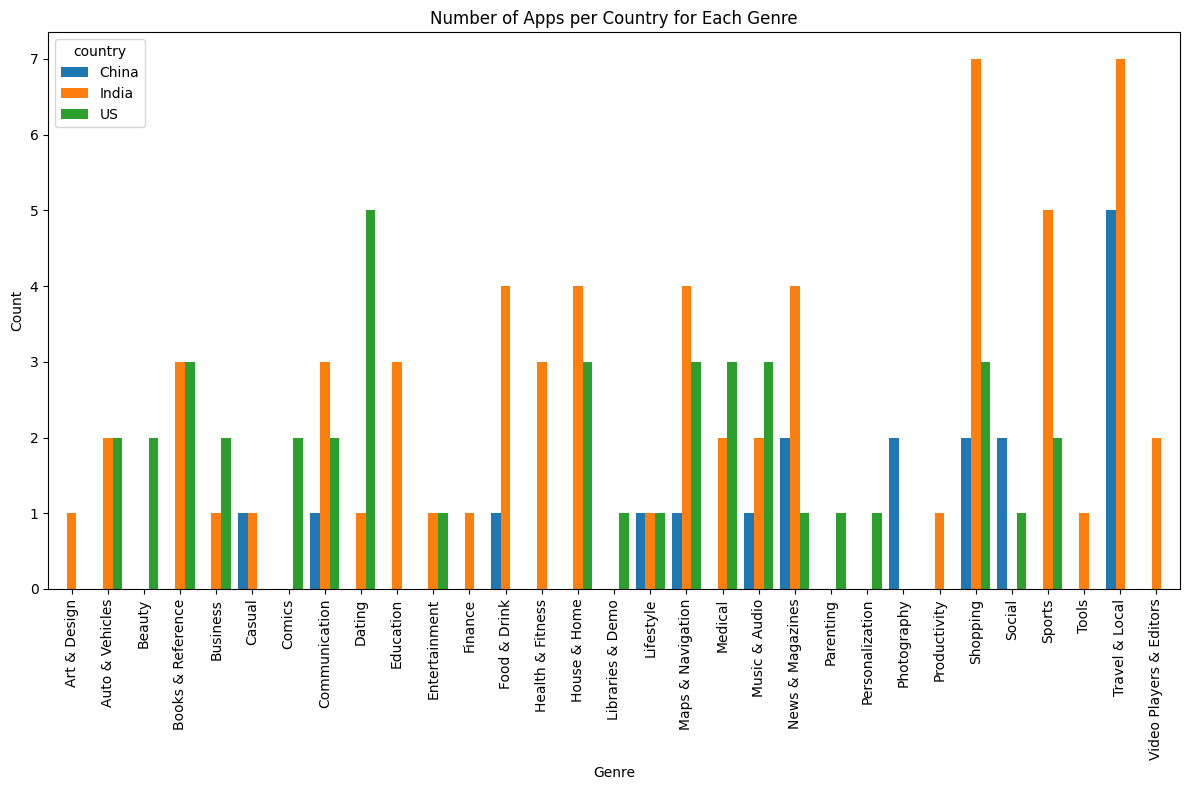

In [48]:
android_df = df[(df.os == 'Android') & (df.genre != 'App not found(404).')]
grouped = android_df[df.os == 'Android'].groupby(['genre', 'country']).country.count().unstack(fill_value=0)

# Create the bar plot
grouped.plot(kind='bar', stacked=False, figsize=(12, 8), width=.8)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Apps per Country for Each Genre')
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('tmp.png')


In [25]:
for genre, group in df.groupby('genre'):
    print(f"~~~~~~~~~~~~~~~~~{genre}")
    print(group.country.value_counts())

~~~~~~~~~~~~~~~~~
country
India    93
US       86
China    81
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~App not found(404).
country
China    85
India    26
US       24
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Art & Design
country
India    1
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Auto & Vehicles
country
India    2
US       2
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Beauty
country
US    2
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Books & Reference
country
India    3
US       3
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Business
country
US       2
India    1
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Casual
country
China    1
India    1
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Comics
country
US    2
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Communication
country
India    3
US       2
China    1
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Dating
country
US       5
India    1
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~Education
country
India    3
Name: count, dtype: int64
~~~~~~